## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
# See all columns 
pd.set_option("display.max.columns", None)

# Summarize the dataset 
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,Wilderness_Area_Neota,Wilderness_Area_Comanche,Wilderness_Area_Poudre,Soil_Type,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,0.447600,0.047000,0.438300,0.067100,0.006000,0.010500,0.00840,0.019800,0.003200,0.013100,0.000200,0.000300,0.00190,0.057000,0.023200,0.049100,0.028800,0.001500,0.0,0.005300,0.006600,0.003200,0.007900,0.016100,0.00160,0.053300,0.096700,0.035200,0.001000,0.003600,0.002200,0.001300,0.197900,0.054400,0.046000,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,0.497272,0.211649,0.496203,0.250208,0.077231,0.101935,0.09127,0.139319,0.056481,0.113709,0.014141,0.017319,0.04355,0.231854,0.150546,0.216088,0.167252,0.038703,0.0,0.072612,0.080976,0.056481,0.088535,0.125866,0.03997,0.224642,0.295564,0.184294,0.031609,0.059895,0.046855,0.036034,0.398436,0.226817,0.209496,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.

The range and mean values vary through the different features, I am going to scale all features to account for this. 

In [3]:
# Seperate feature target 
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

# Preprocess the data 
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# Split data into training and test sets
X_train, X_test, y_train, y_test =  train_test_split(X_scaled, y, test_size = 0.3, random_state = 808)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [5]:
# Initialize SVM model 
svm_model = SVC(random_state = 808)

# Initialize a cross validation object with 5 folds
cv = StratifiedKFold()

# Set up parameter grid 
param_grid_svm = { 'C': [0.1, 1, 10, 100],
                 'kernel': ['linear', 'rbf'],
                 'gamma': ['scale', 'auto']} 

# Set up Grid search for hyperparameter tuning 
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv = cv, n_jobs = 5, verbose = 0)

In [6]:
# Start time
start = time.time()

# Run SVM model 
grid_search_svm.fit(X_train, y_train)

# End time
end = time.time()

# Calculate the total time
total_time = end - start
print(f"Total run time: {total_time:.1f} seconds")


Total run time: 1157.4 seconds


In [9]:
# Print best parameters 
svm_best_params = grid_search_svm.best_params_
print(f'Best parameters for SVM model: {svm_best_params}')

Best parameters for SVM model: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [12]:
# Train a Random Forest model with hyperparameter tuning and fit
param_grid_rf = {'n_estimators': [10, 50, 100, 1000],
                'max_depth': [2,5,10,30],
                'min_samples_split': [2, 5, 10, 20]}

# Initialize random forest 
rf_model = RandomForestClassifier(random_state=808)

# Set up grid search 
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv = cv, n_jobs = 5, verbose = 0)

In [13]:
# Start time
start2 = time.time()

# Run SVM model 
grid_search_rf.fit(X_train, y_train)

# End time
end2 = time.time()

# Calculate the total time
total_time2 = end2 - start2
print(f"Total run time: {total_time:.1f} seconds")

Total run time: 1157.4 seconds


In [14]:
# Print best parameters 
rf_best_params = grid_search_rf.best_params_
print(f'Best parameters for RF model: {rf_best_params}')

Best parameters for RF model: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [16]:
# Initalize SVM model with best parameters
svm_best = SVC(**svm_best_params, random_state = 808)

# Run SVM model
svm_best.fit(X_train, y_train)

# Make SVM test predictions
svm_best_pred = svm_best.predict(X_test)

# Initalize RF model with best parameters 
rf_best = RandomForestClassifier(**rf_best_params, random_state = 808)

# Run RF model
rf_best.fit(X_train, y_train)

# Make RF test predictions
rf_best_pred = rf_best.predict(X_test)


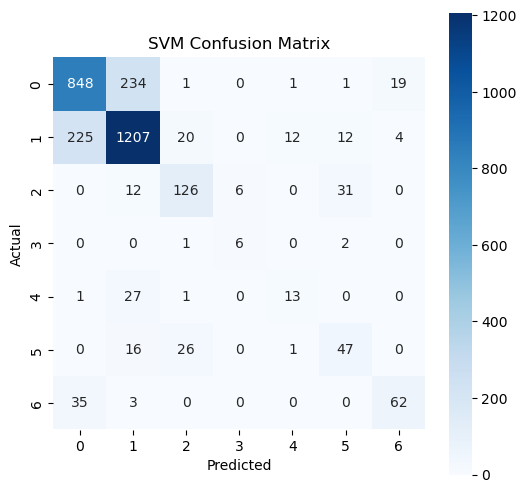

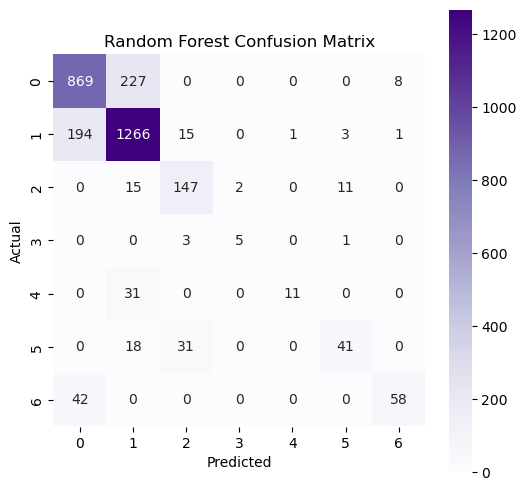

In [20]:
# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_best_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# RF Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_best_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Purples', square=True)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [19]:
# Print accuracy and run time for each model 
print(f'SVM accuracy: {accuracy_score(y_test, svm_best_pred):.3f}')
print(f'SVM model training time: {total_time}')
print(f'\nRF accuracy: {accuracy_score(y_test, rf_best_pred):.3f}')
print(f'RF model training time: {total_time2}')

SVM accuracy: 0.770
SVM model training time: 1157.418624162674

RF accuracy: 0.799
RF model training time: 102.68993377685547


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


**Answer:** In comparing the accuracy scores, the two models performed quite similarily with the RF model score being slightly higher. The main difference between the two models was the training time, with the SVM model taking 19 minutes and the RF model taking a little less than 2 minutes. And finally looking at the confusion matrix, while they seem to have a slightly similar distirbution of errors, how ever there are slightly more predictive errors in the SVM model. 

With similar accuracy and the much greater computing demand of the SVM model, I believe the RF model was more suitable for the task of predicting forest cover type